### Imports

Code adapted from: https://towardsdatascience.com/land-cover-classification-in-satellite-imagery-using-python-ae39dbf2929

In [10]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Sklearn Libraries
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve
from sklearn.metrics import accuracy_score
from pprint import pprint
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC




from sklearn.svm import SVC


### Prepare Data

In [4]:
# Read in our satellite and label image
satellite_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/final_filled_l8_training_data.tif', gdal.GA_ReadOnly)
training_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/third_remerge_landcover_training_data.tif', gdal.GA_ReadOnly)


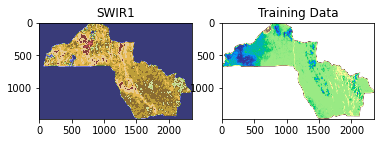

In [5]:

img = np.zeros((satellite_img.RasterYSize, satellite_img.RasterXSize, satellite_img.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(satellite_img.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = satellite_img.GetRasterBand(b + 1).ReadAsArray()
    
lbls = training_img.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.tab20b)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(lbls, cmap=plt.cm.terrain)
plt.title('Training Data')

plt.show()

In [6]:
unique, counts = np.unique(lbls, return_counts=True)
list(zip(unique, counts))

[(1, 120176), (2, 179811), (3, 984873), (4, 4036), (5, 33701), (6, 2166902)]

In [7]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (lbls !=6).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(lbls[lbls !=6])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#this is a quick numpy trick for flattening
X = img[lbls !=6]  # include 8th band, which is Fmask, for now
y = lbls[lbls !=6]


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))



We have 1322597 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (1322597, 7)
Our y array is sized: (1322597,)


## Stratify Data

k-fold

In [6]:
#stratified k-cross validation to balance the classes
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

10

In [7]:
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  34227   34228   34229 ... 1322594 1322595 1322596] TEST: [     0      1      2 ... 166551 166552 166553]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [ 34227  34228  34229 ... 337945 337946 337947]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [ 40507  40509  40783 ... 689696 689697 689698]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [ 43124  43125  43126 ... 749203 749207 749208]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [ 45882  45883  45884 ... 796463 796464 796465]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [ 48240  48241  48242 ... 885464 885465 885469]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [ 50601  50602  50603 ... 997936 997937 997938]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [  53007   53008   53013 ... 1109611 1109612 1109613]
TRAIN: [      0       1       2 ... 1322594 1322595 1322596] TEST: [  5641

shuffle split

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

StratifiedShuffleSplit(n_splits=10, random_state=0)
        
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 516515  598768 1060876 ... 1060356  926656   83758] TEST: [ 308612 1049170  726738 ... 1242672  417470  815476]
TRAIN: [867454 331837 289838 ... 630797 651038 399438] TEST: [ 979140  178008  486077 ...  367931 1130722  797914]
TRAIN: [  76693  814276  691795 ...  307709  446187 1019702] TEST: [1019286  425799  539896 ...  276152  290360  825096]
TRAIN: [ 110656 1046185   30215 ...  882333 1283538  736703] TEST: [ 980936 1049913  444975 ...   44176 1293046 1180039]
TRAIN: [ 827984  782960  588086 ... 1127424  391931  768154] TEST: [ 182281  495117 1196688 ...  347300  622354  326270]
TRAIN: [225684 178532 636670 ... 230313 218759 280230] TEST: [  99160 1109765  371407 ...  577320  923870 1204639]
TRAIN: [226823 678780 141985 ... 233462 726672 363004] TEST: [1195804 1278677  341394 ...  513854 1220833  984517]
TRAIN: [  64712  387273  368864 ...  322534  278136 1245713] TEST: [1063206  990233 1004223 ...  612030  152333  571333]
TRAIN: [611615 725761 227178 ... 519273 220646  18

### Train SVM

In [15]:
#This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of 
#the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength 
#schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method. 
#The loss function defaults to ‘hinge’, which gives a linear SVM.

#tol is the stopping criterion. If it is not None, training will stop when (loss > best_loss - tol) for n_iter_no_change 
#consecutive epochs. Convergence is checked against the training loss or the validation loss depending on the 
#early_stopping parameter.

#learning rate is set to optimal where ‘optimal’: eta = 1.0 / (alpha * (t + t0)) where t0 is chosen by a 
#heuristic proposed by Leon Bottou. 
clf = NuSVC(nu=0.1)

In [16]:
# Fit Data
train = clf.fit(X_train, y_train)

ValueError: specified nu is infeasible

In [10]:
print('The training accuracy is: {score}%'.format(score= train.score(X_train, y_train) * 100))


The training accuracy is: 65.86767792005296%


## Training Performance

In [11]:
# Predict labels for test data
svm_pred = svm.predict(X_test)

In [12]:
target_names = ['Cropland', 'Shrubland', 'Forest', 'Urban', 'Water']

In [13]:
# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")
print(classification_report(y_test, svm_pred, target_names=target_names))

Accuracy: 48.42997451969242
              precision    recall  f1-score   support

    Cropland       0.00      0.00      0.00     12018
   Shrubland       0.14      0.44      0.21     17981
      Forest       0.74      0.57      0.64     98487
       Urban       0.33      0.00      0.00       403
       Water       0.00      0.00      0.00      3370

    accuracy                           0.48    132259
   macro avg       0.24      0.20      0.17    132259
weighted avg       0.57      0.48      0.51    132259



/home/users/joycelyn/miniconda3/envs/mres_proj/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/users/joycelyn/miniconda3/envs/mres_proj/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/users/joycelyn/miniconda3/envs/mres_proj/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Confusion matrix:
[[    0  4235  7783     0     0]
 [    0  7987  9994     0     0]
 [    0 42420 56065     2     0]
 [    0   237   165     1     0]
 [    0  1724  1646     0     0]]


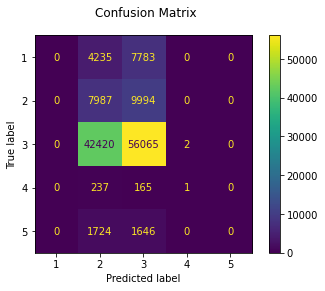

In [14]:
disp = metrics.plot_confusion_matrix(svm, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()